<a href="https://colab.research.google.com/github/cui1104/fraudulent-job-posting-detector/blob/main/JobPosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Fraudulent Job Posting Analysis Notebook

Welcome to this interactive Google Colab notebook, where we'll explore and identify fraudulent job postings. The journey begins with setting up our environment by importing necessary libraries. Next, you'll upload the dataset you wish to analyze. Whether you're a seasoned data scientist or new to the field, this notebook is designed to provide you with the tools and knowledge to dive deep into the data, uncover insights, and develop predictive models. Let's embark on this analytical adventure together, starting with the very first step: importing libraries and uploading your dataset. Happy analyzing!

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import io
from wordcloud import WordCloud
from nltk import bigrams, trigrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from gensim.models import Word2Vec
import re
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

uploaded = files.upload() # upload your dataset here

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving fake_job_postings.csv to fake_job_postings.csv


In this tutorial, we use the dataset from the University of Aegean, consists of real-life job ads posted by Workable, an online employment platform, between 2012 and 2014. The labeled data contains 17,014 real and 866 fraudulent job postings (17,880 in total). You could also try your own datasets.


In [2]:
# Replace 'your_file_name.csv' with the key from the 'uploaded' dictionary
# In our case, our dataset name is "fake_job_postings.csv"
df = pd.read_csv('fake_job_postings.csv')

# Data Wrangling

In [3]:
result = df.dtypes
print(result)

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


In [4]:
# This block will do data preprocessing
cols = []
for col in df.columns:
  cols.append(col)
text_columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function']
for text in text_columns:
  df[text] = df[text].astype("string")
  df[text].fillna('None', inplace=True)

In [5]:
train_df, temp_df, train_labels, temp_labels = train_test_split(df[cols], df['fraudulent'],
                                                                    random_state=0,
                                                                    test_size=0.3,
                                                                    stratify=df['fraudulent'])
val_df, test_df, val_labels, test_labels = train_test_split(temp_df, temp_labels,
                                                                random_state=0,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [6]:
#This block will remove similar job postings (different locations etc.) in data frames using tf-idf
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics.pairwise import cosine_similarity
def remove_similar_job(df, threshold):
  # Create TF-IDF vectors for text
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform(df['description'])

  # Compute cosine similarity matrix
  similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

  # Set to keep track of indices of rows to remove
  rows_to_remove = set()
  encountered = set()

  # Iterate over pairs of similar text
  for i in range(len(similarities)):
    if i in rows_to_remove or i in encountered:
      continue
    else:
      similar_real = 0
      similar_fake = 0
      if df.iloc[i]['fraudulent'] == 0:
        similar_real = 1
      else:
        similar_fake = 1
      for j in range(i + 1, len(similarities[i])):
        if similarities[i][j] >= threshold:
          if df.iloc[j]['fraudulent'] == 0:
            if similar_real == 1:
              rows_to_remove.add(j)
            else:
              similar_real == 1
              encountered.add(j)
          else:
            if similar_fake == 1:
              rows_to_remove.add(j)
            else:
              similar_fake = 1
              encountered.add(j)
  fake_row = []
  for row in rows_to_remove:
    if df.iloc[row]['fraudulent'] == 1:
      fake_row.append(row)
  #print(fake_row)

  # Remove rows containing similar text, keeping only one instance of each group
  df_cleaned = df.drop(rows_to_remove)
  return df_cleaned

threshold = 0.9
df_remove_duplicates = remove_similar_job(df, threshold)
#df_remove_duplicates.to_csv('cleaned_data.csv')

In [8]:
#splits real ad fake dataframes
df_real = df[df['fraudulent'] == 0]
df_fake = df[df['fraudulent'] == 1]

# Exploratory Data Analysis



 Next, let us do some explorations on the textual features. We will show how to

*   generate word clouds
*   generate radar plots

steps by steps.



In [9]:
dataset_name = input("Enter the name of the dataset you want to test: ")
# You can either try the exploratory textual data analysis with 'df' or 'df_remove_duplicates' here.
# In our case, we use 'df'
df_eda = eval(dataset_name)

Enter the name of the dataset you want to test: df


In [10]:
df_eda.fillna(' ', inplace=True)
df_eda['text']=df_eda['title']+' '+df_eda['location']+' '+df_eda['company_profile']+' '+df_eda['description']+' '+df_eda['requirements']+' '+df_eda['benefits']

real_jobs = df_eda[df_eda['fraudulent'] == 0].text
fake_jobs = df_eda[df_eda['fraudulent'] == 1].text

def create_frequency_dict_ngrams(text_series, n, remove_stop_words=True):
    ngram_freq = Counter()
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set()

    for text in text_series:
        words = word_tokenize(text.lower())
        if remove_stop_words:
            words = [word for word in words if word.isalpha() and word not in stop_words]
        # Use n to create unigrams, bigrams, trigrams, etc.
        if n == 1:
            ngrams = words
        elif n == 2:
            ngrams = bigrams(words)
        elif n == 3:
            ngrams = trigrams(words)
        else:
            ngrams = zip(*[words[i:] for i in range(n)])  # for n-grams where n > 3
        # Update the frequency counter with the ngrams
        if n == 1:
            ngram_freq.update(ngrams)
        else:
            ngram_freq.update([' '.join(gram) for gram in ngrams])
    return ngram_freq

In [11]:
# You can create bag-of-words for ngram of either real or fake job posts' texts.
real_onegram_freq = create_frequency_dict_ngrams(real_jobs, n=1, remove_stop_words=True)
fake_onegram_freq = create_frequency_dict_ngrams(fake_jobs, n=1, remove_stop_words=True)
real_bigram_freq = create_frequency_dict_ngrams(real_jobs, n=2, remove_stop_words=True)
fake_bigram_freq = create_frequency_dict_ngrams(fake_jobs, n=2, remove_stop_words=True)
def create_frequency_word_cloud(real_series, fake_series):
  # Generate word cloud for real job descriptions
  real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(real_series)

  # Generate word cloud for fake job descriptions
  fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_series)

  # Display the word clouds
  plt.figure(figsize=(15, 10))

  # Real job word cloud
  plt.subplot(1, 2, 1)
  plt.imshow(real_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud for Real Job Descriptions')

  # Fake job word cloud
  plt.subplot(1, 2, 2)
  plt.imshow(fake_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud for Fake Job Descriptions')

  # Show the plots
  plt.show()
  return None

In [12]:
# This block is optional, since you could choose either excluding the common words or not when generating the word clouds.
# In our case, we excluded the top 50 common words in both bags-of-words.
N = 50
top_real_words = {word for word, freq in real_onegram_freq.most_common(N)}
top_fake_words = {word for word, freq in fake_onegram_freq.most_common(N)}
common_words = top_real_words.intersection(top_fake_words)

def create_frequency_dict_ngrams_excluding_common(text_series, n, remove_stop_words=True, common_words=set()):
    ngram_freq = Counter()
    if remove_stop_words:
        stop_words = set(stopwords.words('english')).union(common_words)
    else:
        stop_words = common_words
    for text in text_series:
        words = word_tokenize(text.lower())
        if remove_stop_words:
            words = [word for word in words if word.isalpha() and word not in stop_words]
        if n == 1:
            ngrams = words
        elif n == 2:
            ngrams = bigrams(words)
        elif n == 3:
            ngrams = trigrams(words)
        else:
            ngrams = zip(*[words[i:] for i in range(n)])
        if n == 1:
            ngram_freq.update(ngrams)
        else:
            ngram_freq.update([' '.join(gram) for gram in ngrams])
    return ngram_freq

# Now exclude common words when generating frequencies
real_onegram_freq_excl_common = create_frequency_dict_ngrams_excluding_common(real_jobs, n=1, remove_stop_words=True, common_words=common_words)
fake_onegram_freq_excl_common = create_frequency_dict_ngrams_excluding_common(fake_jobs, n=1, remove_stop_words=True, common_words=common_words)

# Similarly for bigrams, if desired
real_bigram_freq_excl_common = create_frequency_dict_ngrams_excluding_common(real_jobs, n=2, remove_stop_words=True, common_words=common_words)
fake_bigram_freq_excl_common = create_frequency_dict_ngrams_excluding_common(fake_jobs, n=2, remove_stop_words=True, common_words=common_words)

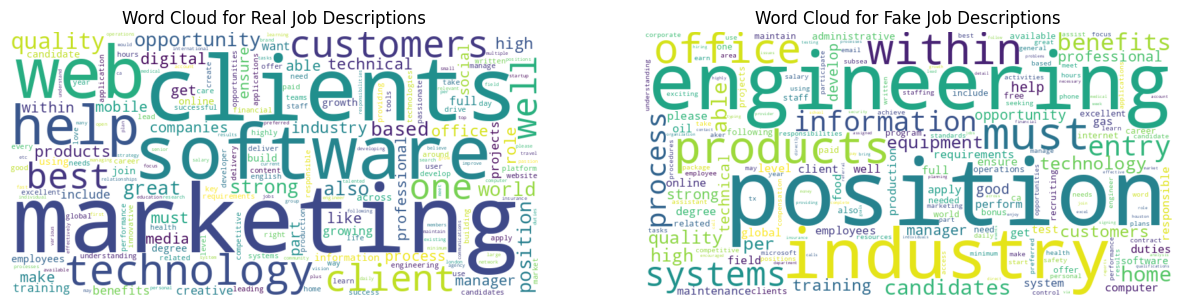

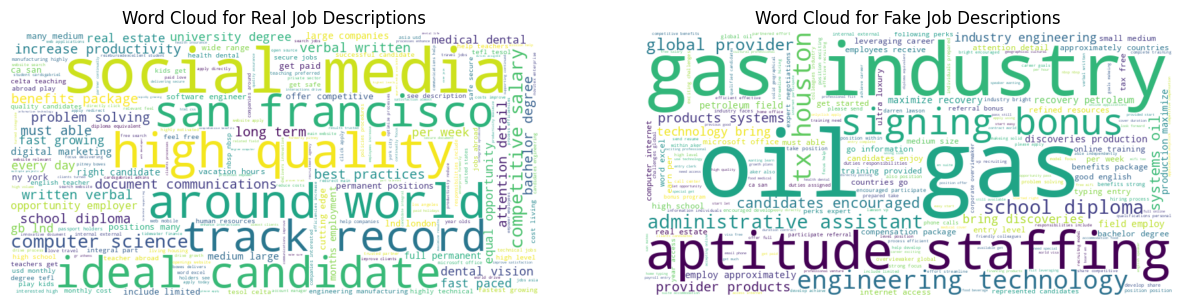

In [13]:
# Generate and display the word clouds excluding common words.
# Simply input the real and fake job texts' bag-of-words for the word cloud generating function.

create_frequency_word_cloud(real_onegram_freq_excl_common, fake_onegram_freq_excl_common)
create_frequency_word_cloud(real_bigram_freq_excl_common, fake_bigram_freq_excl_common)
# If you skip the last block, simply comment the two lines above and uncomment the two lines below to generate the word clouds!
# create_frequency_word_cloud(real_onegram_freq, fake_onegram_freq)
# create_frequency_word_cloud(real_bigram_freq, fake_bigram_freq)

In [14]:
def calculate_disproportionate_words(fake_freq, real_freq):
    # Combine the keys from both Counters and calculate the scores
    all_words = set(fake_freq) | set(real_freq)
    word_scores = {word: (fake_freq[word] / (real_freq[word] + 1)) for word in all_words}

    sorted_word_scores = sorted(word_scores.items(), key=lambda item: item[1], reverse=True)
    return sorted_word_scores

# In our case, we plotted the radar plot for the single words only. You could also try bigram or trigram
sorted_word_scores = calculate_disproportionate_words(fake_onegram_freq, real_onegram_freq)
top_n_words = sorted_word_scores[:200]
#print(top_n_words)
sorted_word_scores2 = calculate_disproportionate_words(fake_bigram_freq, real_bigram_freq)
top_n_words2 = sorted_word_scores2[:200]
#print(top_n_words2)

For next step, we need to identify some "key words". This is based on your knowledge of your dataset, or identified based on the scores for the words in the fake job postings using "top_n_words" in the last block.
You might need to do this manually because many top words with high scores are actually the name of some companies that only
appear in the fake jobs. Therefore, selection of the key words from the fake job postings is essential and needs hard coding.

In [15]:
total_real_jobs = len(real_jobs)
total_fake_jobs = len(fake_jobs)
normalized_real_freq = {word: freq / total_real_jobs for word, freq in real_onegram_freq.items()}
normalized_fake_freq = {word: freq / total_fake_jobs for word, freq in fake_onegram_freq.items()}

# Key words for the radar plot
key_words = [
    "ultra", "tenured", "luxury",
    "maximize", "easy", "home", "entry", "opportunity",
    "online", "free", "recruiting", "bonus", "extra",
    "encouraged", "participate"
]
# Notice: Please choose 15 key words you believe are disproportionally common in the fake job postings.

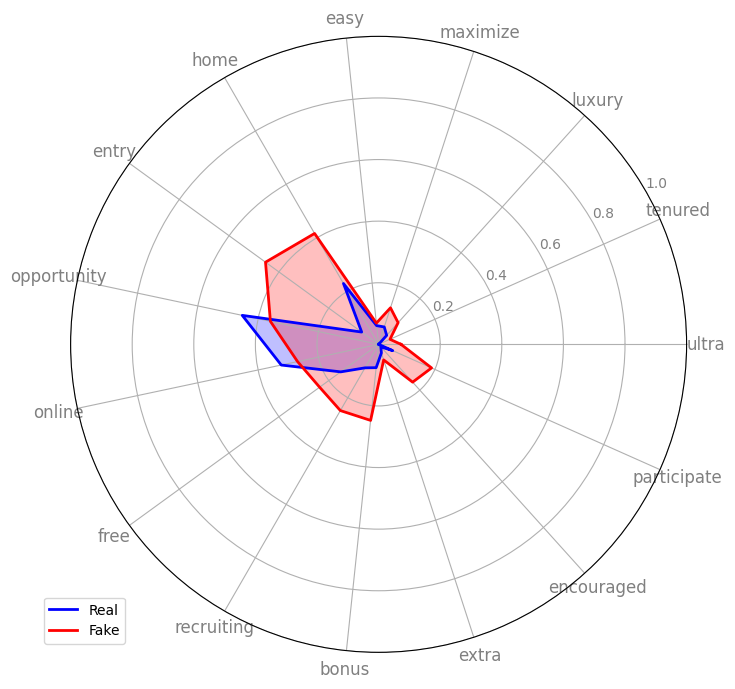

In [16]:
# Extract normalized frequencies for the radar plot
freqs_real_normalized = [normalized_real_freq.get(word, 0) for word in key_words]
freqs_fake_normalized = [normalized_fake_freq.get(word, 0) for word in key_words]

num_vars = len(key_words)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

freqs_real_normalized += freqs_real_normalized[:1]
freqs_fake_normalized += freqs_fake_normalized[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], key_words, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=10)
plt.ylim(0)

# Plot data
ax.plot(angles, freqs_real_normalized, color='blue', linewidth=2, linestyle='solid', label='Real')
ax.fill(angles, freqs_real_normalized, color='blue', alpha=0.25)

ax.plot(angles, freqs_fake_normalized, color='red', linewidth=2, linestyle='solid', label='Fake')
ax.fill(angles, freqs_fake_normalized, color='red', alpha=0.25)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

# Feature Engineering

data cleaing here:
first non-textual features //
  length feature //
word embedding here

For the textual features, we need to implement word embedding models. There are many popular models choices. We will implement Word2Vec, GloVe, and Doc2Vec, then use t-SNE strategy to visualize the word embedding results and decide which model is optimal.

In [19]:
# We will continue to use df_prepared for feature engineering.
df_prepared = df_remove_duplicates.copy()
df_prepared['combined_text'] = df_prepared[['company_profile', 'description', 'requirements', 'benefits']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'\W+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # Rejoin tokens into a single string
    clean_text = ' '.join(lemmatized_tokens)
    return clean_text

# Apply the preprocessing function to the combined text column
# Combine the four textual features, clean them
df_prepared['clean_combined_text'] = df_prepared['combined_text'].apply(preprocess_text)

In [20]:
df_prepared['tokens'] = df_prepared['clean_combined_text'].apply(lambda x: x.split())
# Prepare data: a list of lists of tokens
sentences = df_prepared['tokens'].tolist()
# Train a Word2Vec model first, you could adjust the vector_size, window, min_count, workers based on your dataset
model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

In [21]:
def document_vector(model, doc):
    # Remove out-of-vocabulary words
    words = [word for word in doc if word in model.wv.key_to_index]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)
# Apply the function to each document
df_prepared['doc_vector_word2vec'] = df_prepared['tokens'].apply(lambda doc: document_vector(model, doc))

In [22]:
# You could skip this block if you do not want to save the Word2Vec model
model.save("my_word2vec_model.model")
model = Word2Vec.load("my_word2vec_model.model")